In [240]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `c:\Users\sesch\Git\tinympc-julia\quadrotor_quat\Project.toml`

In [241]:
using LinearAlgebra
using Plots
using Printf

In [300]:
#2D Double-integrator dynamics
h = 0.05 #20 Hz
A = [I(2) h*I(2); zeros(2,2) I(2)]
B = [0.5*h*h*I(2); h*I(2)];

In [301]:
#Reference state trajectory to track (origin)
t = 0:h:10
N = length(t)
xref = [[sin(i*h), 0.0, 0.0, 0.0] for i = 1:N];

#Reference input trajectory
uref = [zeros(2) for i = 1:N-1];

nu = 2;
nx = 4;

In [308]:
#Cost Function
# J = Σ 0.5*(x-xref)'*Q*(x-xref) + 0.5*(u-uref)*R*(u-uref) + 0.5*xn'*Qn*xn
Qn = 10.0*I(4)
Q = 10.0*I(4)
R = 0.1*I(2)

q = [zeros(4) for i = 1:N];
r = [zeros(2) for i = 1:N-1];


#Algorithm Setup
umin = -[10.0; 10.0]
umax = [10.0; 10.0];

x = [zeros(4) for i = 1:N];
x[1] .= [.1; 0; 0; 1.0]
u = [zeros(2) for i = 1:N-1];

ρ = 1.0
R̃ = R + ρ*I

P = [zeros(4, 4) for i = 1:N];
P[N] .= Qn
p = [zeros(4) for i = 1:N];
p[N] .= q[N]

K = [zeros(2, 4) for i = 1:N-1];
m = [zeros(2) for i = 1:N-1];

w = [zeros(2) for i = 1:N-1];
wnew = [zeros(2) for i = 1:N-1];
y = [zeros(2) for i = 1:N-1];

# Precompute
cache = (
    Ã = A,
    B̃ = B,
    Kinf = zeros(nu,nx),
    Pinf = zeros(nx,nx),
    Quu_inv = zeros(nu,nu),
    AmBKt = zeros(nx,nx), 
    coeff_d2p = zeros(nx,nu), 
)

# Riccati backward pass
max_IHLQR_iters = N
P[max_IHLQR_iters] .= Qn
for k = (max_IHLQR_iters-1):-1:1
    K[k] .= (R̃ + cache.B̃'*P[k+1]*cache.B̃)\(cache.B̃'*P[k+1]*cache.Ã)
    P[k] .= Q + cache.Ã'*P[k+1]*(cache.Ã - cache.B̃*K[k])
end

cache.Kinf .= K[1]
cache.Pinf .= P[1]
cache.Quu_inv .= (R̃ + cache.B̃'*cache.Pinf*cache.B̃)\I;
cache.AmBKt .= (cache.Ã - cache.B̃*cache.Kinf)'
cache.coeff_d2p .= cache.Kinf'*R̃ - cache.AmBKt*cache.Pinf*cache.B̃;

params = (
    nx = 4, nu = 2,
    N = N, Q = Q, R = R, R̃ = R̃, Qf = Qn,
    umin = umin, umax = umax,
    Xref = xref, Uref = uref, 
    h = h, cache = cache
);

In [309]:
include("tinyMPC-ADMM-dt.jl")
# Simulation
u, status = solve_admm!(params, q, r, p, m, x, u, w, wnew, y; ρ=ρ, abs_tol=1e-2, max_iter=100)


29

([3.6101121705351735, -8.492484559934756], 1)

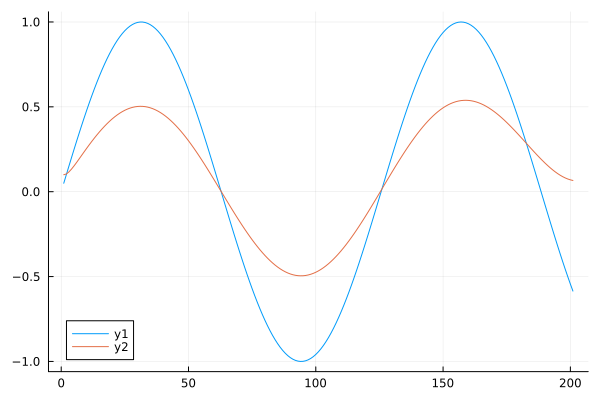

In [310]:
xref_m = hcat(xref...)
x_m = hcat(x...)
plot(xref_m[1,:])
plot!(x_m[1,:])

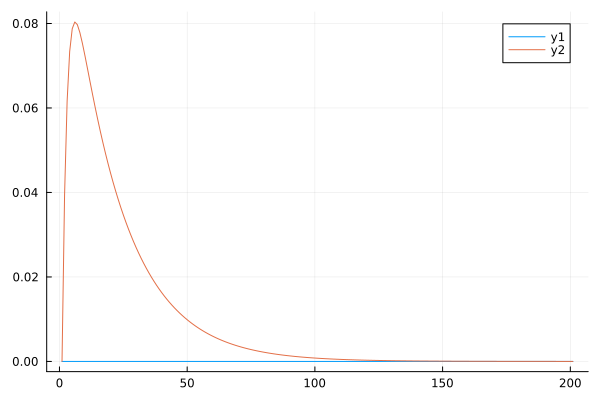

In [249]:
plot(xref_m[2,:])
plot!(x_m[2,:])